<h1><b>NEURAL STYLE TRANSFER</b></h1>

<h2><b>1.Importing Model</b></h2>

In [0]:
import tensorflow as tf


from tensorflow.python.keras.applications.vgg19 import VGG19 #importing pretrained vgg19 model

In [63]:
model = VGG19(
    include_top = False, #we don't need top layer as we don't require final output of model we need the features from layers
    weights = 'imagenet' #imagenet is dataset by which vgg19 is trained
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

<h2><b>2.Importing Libraries and Helper Functions</b></h2>

In [0]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h2><b>3.Image Preprocessing and Display</b></h2>

In [0]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

In [0]:
def deprocess(x):
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4: #checking if image is 4D
        img = np.squeeze(image, axis = 0)

    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

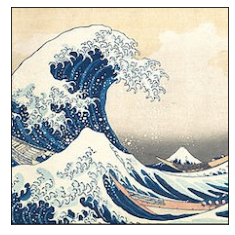

In [67]:
img = load_and_process_image('/style.jpg')
display_image(img)

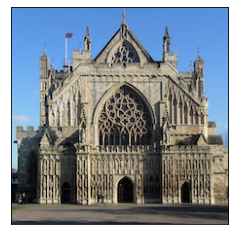

In [68]:
img = load_and_process_image('/content.jpg')
display_image(img)

<h2><b>4.Content and Style Models</b></h2>

In [0]:
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
] #selecting the layers, using 3 different layers to extract different kind of stylistic features

content_layer = 'block5_conv2' #using block 5's 2nd conv layer which is quite deep

# intermediate models
#activation of intermmediate layers
content_model = Model(
    inputs = model.input, #same input as VGG19 model is having
    outputs = model.get_layer(content_layer).output #but output will be different i.e. from content layer
)

style_models = [Model(inputs = model.input, 
                      outputs = model.get_layer(layer).output) for layer in style_layers]

<h2><b>5.Content Cost</b></h2>

In [0]:
# Content Cost
def content_cost(content, generated):
    a_C = content_model(content) #calculating activation of content image
    a_G = content_model(generated) #calculating activation of generated image
    cost = tf.reduce_mean(tf.square(a_C - a_G)) #calculating mean squared difference
    return cost

<h2><b>6.Gram Matrix</b></h2>

In [0]:
def gram_matrix(A):
    channels = int(A.shape[-1]) #finding number of channels
    a = tf.reshape(A, [-1, channels]) 
    #reshaping matrix in a way instead of being a 3D array it converts into 2D like if we are having a matrix of size 200*200*3 then it will be converted into matrix of 200*200 where no. of channels are 3.
    n = tf.shape(a)[0] #number of elements we get after reshaping
    gram = tf.matmul(a, a, transpose_a = True) #calculating gram matrix which is simple a*a_transpose
    return gram / tf.cast(n, tf.float32) #scaling it by number of elements

<h2><b>7.Style Cost</b></h2>

In [0]:
'''We have bunch of style models each coressponding to different
intermmediate layer from vgg19 model. Style cost is weighted 
sum of costs of each of the style models'''

lam = 1. / len(style_models) #Calculating weight assuming that weigh each style model is same

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style) #activation of style image
        a_G = style_model(generated) #activation of generated image
        GS = gram_matrix(a_S) #gram matrix for style image
        GG = gram_matrix(a_G) #gram matrix for generated image
        current_cost = tf.reduce_mean(tf.square(GS - GG)) #MSD b/w gram matrices which gives feature correlation
        J_style += current_cost * lam #adding to overall cost
    
    return J_style

In [73]:
tf.executing_eagerly()

True

<h2><b>8.Training Loop</b></h2>

In [0]:
import time

generated_images = [] #to store some intermmediate results

def training_loop(content_path, style_path, iterations = 20, a = 10., b = 20.): #a & b are weights
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype = tf.float32)
    
    opt = tf.optimizers.Adam(learning_rate = 7.) #Adam optimizer
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape: #API for automatic differentiation
            J_content = content_cost(content, generated) #calculating content cost
            J_style = style_cost(style, generated) #calculating style cost
            J_total = a * J_content + b * J_style #calculating total cost
        
        grads = tape.gradient(J_total, generated) #calculating gradient
        opt.apply_gradients([(grads, generated)]) #applying optimizer on gradients
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [75]:
final = training_loop('/content.jpg','/style.jpg')

Cost at 0: 13733986304.0. Time elapsed: 17.705535173416138
Cost at 2: 5336611840.0. Time elapsed: 48.68281149864197
Cost at 4: 3317499136.0. Time elapsed: 79.27016687393188
Cost at 6: 2499667200.0. Time elapsed: 109.88997530937195
Cost at 8: 2034289280.0. Time elapsed: 140.43655014038086
Cost at 10: 1641282304.0. Time elapsed: 170.95978689193726
Cost at 12: 1319639296.0. Time elapsed: 201.48517274856567
Cost at 14: 1100252416.0. Time elapsed: 232.8343951702118
Cost at 16: 955011648.0. Time elapsed: 262.5618345737457
Cost at 18: 836550400.0. Time elapsed: 293.30222272872925


<h2><b>9.Display Intermediate Images</b></h2>

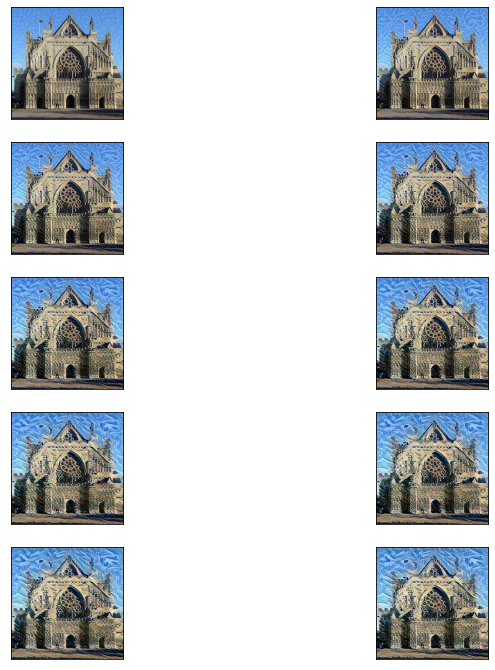

In [76]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()

<h2><b>10.Final Image</b></h2>

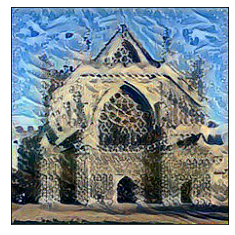

In [77]:
display_image(final)